In [2]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from scipy.stats import special_ortho_group

# First of all we set a readable font size
plt.rcParams.update({'font.size': 16})

# Set seed
np.random.seed(42)

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

# Constants

TEACHER_LAYER_DIM = 20
MAX_STUDENT_HIDDEN_DIMS = TEACHER_LAYER_DIM*10

TRAIN_SIZE = 100000

EPOCHS = 150
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

REG_KIND = 'l2'
REG_COEFF = 0.001
INCREMENT = 0 # Regularization increment on the eigenvalues' diagonalsclass CubicActivation(nn.Module):
    

class TeacherNetwork(nn.Module):
    def __init__(self, dimension):
        super().__init__()

        self.dimension = dimension

        # Initialize rotation matrix (input_dimension, number_of_middle_neurons)

        rotation_matrix = torch.nn.Parameter(
            torch.tensor(special_ortho_group.rvs(dimension), dtype=torch.float32)
        )

        # Define linear layers with rotatoion matrix

        self.first_transfer = nn.Linear(dimension, dimension, bias=False)
        self.first_transfer.weight = torch.nn.Parameter(rotation_matrix)
        self.non_linearity = nn.ReLU()
        self.second_transfer = nn.Linear(dimension, dimension, bias=False)
        self.second_transfer.weight = torch.nn.Parameter(rotation_matrix)


    def forward(self, x):
        x = self.non_linearity(self.first_transfer(x))
        x = self.second_transfer(x)
        return x

class Phi3Network(nn.Module):
    def __init__(self, input_dimension, output_dimension, max_number_of_hidden_neurons):
        super().__init__()

        self.input_dim = input_dimension
        self.hidden_dim_1 = max_number_of_hidden_neurons
        self.hidden_dim_2 = max_number_of_hidden_neurons
        self.output_dim = output_dimension

        self.varphi1 = nn.Parameter(torch.empty(self.hidden_dim_1, self.input_dim), requires_grad=True)
        self.varphi2 = nn.Parameter(torch.empty(self.hidden_dim_2, self.hidden_dim_1), requires_grad=True)
        self.varphi3 = nn.Parameter(torch.empty(self.output_dim, self.hidden_dim_1), requires_grad=True)

        self.l2_diag = nn.Parameter(torch.empty(self.hidden_dim_1), requires_grad=True)
        self.l3_diag = nn.Parameter(torch.empty(self.hidden_dim_2), requires_grad=True)
        self.l4_diag = nn.Parameter(torch.empty(self.output_dim), requires_grad=True)

        self.activation = nn.ReLU()

        nn.init.xavier_uniform_(self.varphi1)
        nn.init.xavier_uniform_(self.varphi2)
        nn.init.xavier_uniform_(self.varphi3)

        with torch.no_grad():
            self.l2_diag.fill_(0.)
            self.l3_diag.fill_(0.)
            self.l4_diag.fill_(1.)

    def count_active_hidden_layers(self, threshold):
        active_layers = 0

        for elem in self.l2_diag:
            if torch.abs(elem) >= threshold:
                active_layers += 1
                break

        for elem in self.l3_diag:
            if torch.abs(elem) >= threshold:
                active_layers += 1
                break

        return active_layers

    def trim_inactive_nodes(self, threshold):
        number_of_trimmed_nodes = 0
        with torch.no_grad():
            for elem in self.l2_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1
            for elem in self.l3_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1
            for elem in self.l4_diag:
                if torch.abs(elem) < threshold:
                    elem.fill_(0.)
                    number_of_trimmed_nodes += 1

        return number_of_trimmed_nodes

    def trim_inactive_layers(self, threshold):
        trimmed_layers = 0
        with torch.no_grad():
            if torch.all(torch.abs(self.l2_diag) < threshold):
                self.l2_diag.fill_(0.)
                trimmed_layers+= 1
            if torch.all(torch.abs(self.l3_diag) < threshold):
                self.l3_diag.fill_(0.)
                trimmed_layers += 1

        return trimmed_layers

    def forward(self, x):
        l2 = torch.diag(self.l2_diag)
        l3 = torch.diag(self.l3_diag)
        l4 = torch.diag(self.l4_diag)

        W_21 = - torch.mm(l2, self.varphi1)
        W_32 = torch.mm(self.varphi2, l2) - torch.mm(l3, self.varphi2)
        W_43 = torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3)
        W_31 = torch.mm(
            torch.mm(l3, self.varphi2) - torch.mm(self.varphi2, l2),
            self.varphi1
        )
        W_42 = torch.mm(
            torch.mm(l4, self.varphi3) - torch.mm(self.varphi3, l3),
            self.varphi2
        )
        W_41 = torch.mm(
            torch.mm(
                torch.mm(self.varphi3, l3) - torch.mm(l4, self.varphi3),
                self.varphi2
            ),
            self.varphi1
        )

        y = torch.mm(W_41, x.t()) + \
            torch.mm(W_42, self.activation(torch.mm(W_21, x.t()))) + \
            torch.mm(
                W_43, self.activation(torch.mm(W_32, self.activation(torch.mm(W_21, x.t()))) + torch.mm(W_31, x.t()))
                )

        return y.t()

class MyDataset(Dataset):
    def __init__(self, input_vectors, teacher, device):
        self.input_vectors = torch.tensor(input_vectors, dtype=torch.float32).to(device)
        self.teacher_outputs = teacher(self.input_vectors).detach()

    def __len__(self):
        return len(self.input_vectors)

    def __getitem__(self, idx):
        return self.input_vectors[idx], self.teacher_outputs[idx]

Using GPU


In [3]:
# Generate teacher network

teacher_network = TeacherNetwork(TEACHER_LAYER_DIM).to(device)

# Print teacher network

print('Teacher network:')
print(teacher_network)

# Generate random input vectors with entries in [-1,1]

train_input_vectors = np.random.rand(TRAIN_SIZE, TEACHER_LAYER_DIM)*2 - 1
test_input_vectors = np.random.rand(TRAIN_SIZE, TEACHER_LAYER_DIM)*2 - 1

# Generate datasets

train_dataset = MyDataset(train_input_vectors, teacher_network, device)
test_dataset = MyDataset(test_input_vectors, teacher_network, device)

# Generate dataloader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Generate student network

student_network = Phi3Network(
    input_dimension=TEACHER_LAYER_DIM,
    output_dimension=TEACHER_LAYER_DIM,
    max_number_of_hidden_neurons=MAX_STUDENT_HIDDEN_DIMS
).to(device)

# Print student parameters

print('Student parameters:')
for name, param in student_network.named_parameters():
    print(name, param.shape)

Teacher network:
TeacherNetwork(
  (first_transfer): Linear(in_features=20, out_features=20, bias=False)
  (non_linearity): ReLU()
  (second_transfer): Linear(in_features=20, out_features=20, bias=False)
)
Student parameters:
varphi1 torch.Size([200, 20])
varphi2 torch.Size([200, 200])
varphi3 torch.Size([20, 200])
l2_diag torch.Size([200])
l3_diag torch.Size([200])
l4_diag torch.Size([20])


In [4]:
# Define optimizer
optimizer = Adam(student_network.parameters(), lr=LEARNING_RATE)
# Define criterion
criterion = nn.MSELoss()

if REG_KIND == None:
    print('Training without regularization')
elif REG_KIND == 'l2':
    print('Training with L2 regularization, and increment', INCREMENT)
elif REG_KIND == 'l1':
    print('Training with L1 regularization, and increment', INCREMENT)
else:
    raise ValueError('Unknown regularization kind')

total_losses = []
total_losses_with_reg = []

# Train student network
for epoch in tqdm(range(EPOCHS)):
    total_loss = 0
    total_loss_with_reg = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = student_network(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item()

        if REG_KIND == None:
            pass
        elif REG_KIND == 'l2':
            loss += (1+INCREMENT)*REG_COEFF * torch.norm(student_network.l2_diag, p=2) + \
                    REG_COEFF * torch.norm(student_network.l3_diag, p=2)
        else:
            loss += (1+INCREMENT)*REG_COEFF * torch.norm(student_network.l2_diag, p=1) + \
                    REG_COEFF * torch.norm(student_network.l3_diag, p=1)

        total_loss_with_reg += loss.item()
        loss.backward()
        optimizer.step()

    total_losses.append(total_loss)
    total_losses_with_reg.append(total_loss_with_reg)


Training with L2 regularization, and increment 0


  0%|          | 0/150 [00:00<?, ?it/s]

In [5]:
# After training R2
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Inizializza liste vuote per raccogliere i dati
x_true = []
y_true = []

# Itera attraverso il train dataloader
for batch in train_dataloader:
    x_batch, y_batch = batch
    x_true.append(x_batch)
    y_true.append(y_batch)

# Itera attraverso il test dataloader
for batch in test_dataloader:
    x_batch, y_batch = batch
    x_true.append(x_batch)
    y_true.append(y_batch)

# Concatena i batch in tensori singoli
x_true = torch.cat(x_true, dim=0)
y_true = torch.cat(y_true, dim=0)

with torch.no_grad():
    y_pred = student_network(x_true)
    print('R2 score NN:', r2_score(y_true.cpu().numpy(), y_pred.cpu().numpy()))

#NUMPY DATASET
# Initialize empty lists to collect data
x_true = []
y_true = []

# Iterate through the train dataloader
for batch in train_dataloader:
    x_batch, y_batch = batch
    x_true.append(x_batch.cpu().numpy())
    y_true.append(y_batch.cpu().numpy())

# Iterate through the test dataloader
for batch in test_dataloader:
    x_batch, y_batch = batch
    x_true.append(x_batch.cpu().numpy())
    y_true.append(y_batch.cpu().numpy())

# Concatenate the batches into single arrays
x_true = np.concatenate(x_true, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Fit a linear model
model = LinearRegression()
model.fit(x_true, y_true)

# Predict using the model
y_pred = model.predict(x_true)

# Calculate R² score
r2 = r2_score(y_true, y_pred)
print('R2 score Linear Model:', r2)

# Calculate Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print('Mean Squared Error:', mse)

R2 score NN: 0.9983161091804504
R2 score Linear Model: 0.7385050654411316
Mean Squared Error: 0.029494037851691246


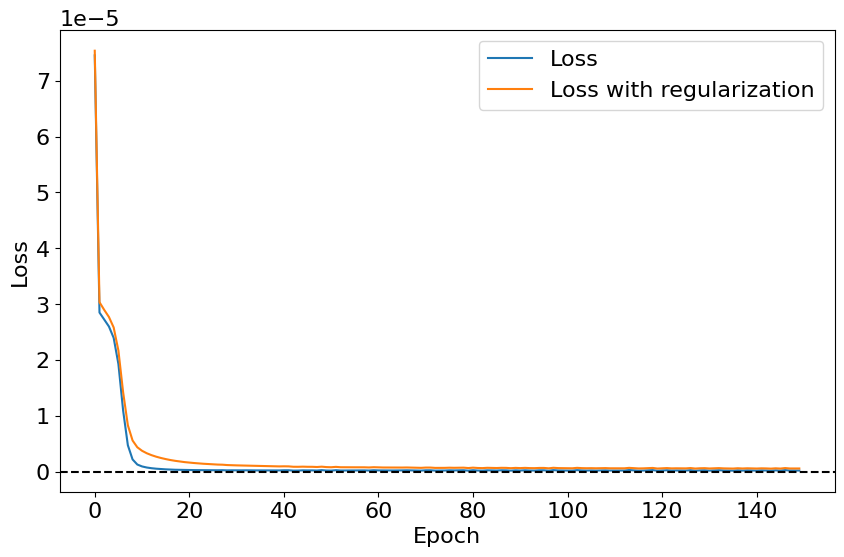

In [6]:
# Make loss plot

plt.figure(figsize=(10, 6))

mean_total_losses = [total_loss/TRAIN_SIZE for total_loss in total_losses]
mean_total_losses_with_reg = [total_loss/TRAIN_SIZE for total_loss in total_losses_with_reg]

plt.plot(mean_total_losses, label='Loss')
plt.plot(mean_total_losses_with_reg, label='Loss with regularization')

plt.axhline(y=0, color='black', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

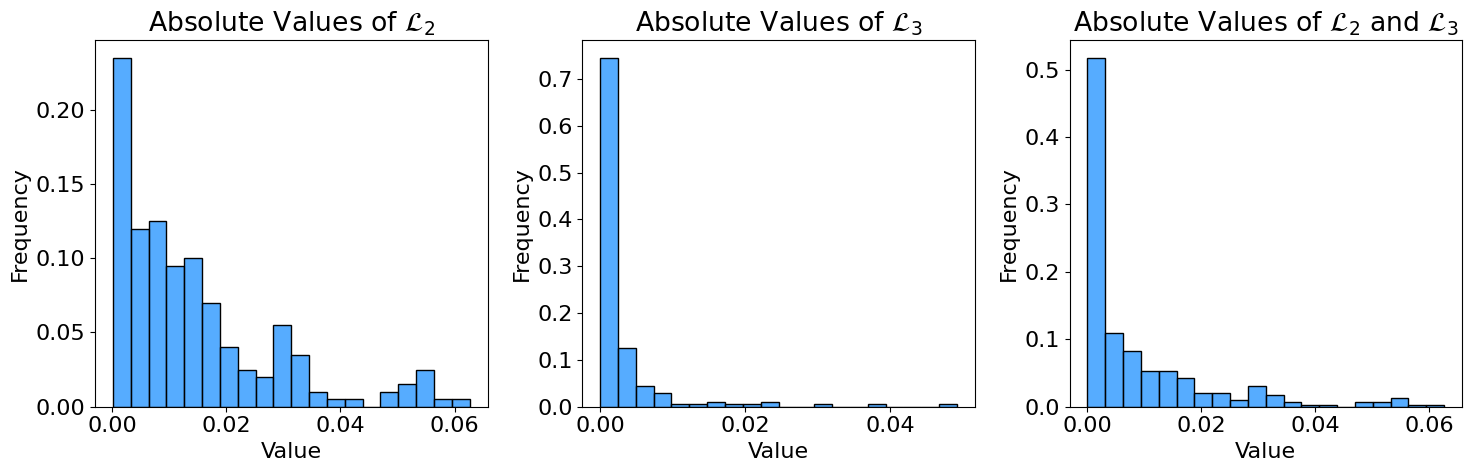

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming per_layer_diags is already populated as per your previous code
per_layer_diags = {}
for name, param in student_network.named_parameters():
    if 'diag' in name:
        per_layer_diags[name] = param.detach().cpu().numpy()

# Create a single figure with 3 subplots
plt.figure(figsize=(15, 5))
M = 10
# Plot absolute values for l_2diag
if 'l2_diag' in per_layer_diags:
    param_values = per_layer_diags['l2_diag']
    bins = len(param_values.flatten()) // M
    plt.subplot(1, 3, 1)
    sns.histplot(np.abs(param_values.flatten()), bins=bins, kde=False, color='dodgerblue', alpha=0.75, stat='probability')
    plt.title(r'Absolute Values of $\mathcal{L}_2$')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# Plot absolute values for l_3diag
if 'l3_diag' in per_layer_diags:
    param_values = per_layer_diags['l3_diag']
    bins = len(param_values.flatten()) // M
    plt.subplot(1, 3, 2)
    sns.histplot(np.abs(param_values.flatten()), bins=bins, kde=False, color='dodgerblue', alpha=0.75, stat='probability')
    plt.title(r'Absolute Values of $\mathcal{L}_3$')
    plt.xlabel('Value')
    plt.ylabel('Frequency')


if 'l2_diag' in per_layer_diags and 'l3_diag' in per_layer_diags:
    all_values = np.concatenate([
        np.abs(per_layer_diags['l2_diag'].flatten()),
        np.abs(per_layer_diags['l3_diag'].flatten())
    ])
    bins = len(all_values) // (2*M)
    plt.subplot(1, 3, 3)
    sns.histplot(all_values, bins=bins, kde=False, color='dodgerblue', alpha=0.75, stat='probability')
    plt.title(r'Absolute Values of $\mathcal{L}_2$ and $\mathcal{L}_3$')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
from copy import deepcopy
# Test the student network before trimming
PRUNING_THRESHOLD = 0.01

student_network.eval()
with torch.no_grad():
    test_loss = 0
    for x_batch, y_batch in test_dataloader:
        y_pred = student_network(x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
    mean_test_loss_before_trimming = test_loss/TRAIN_SIZE
    print('Mean test loss before trimming:', mean_test_loss_before_trimming)


trimmed_net  = deepcopy(student_network)
# Trim the student network and test again

number_of_trimmed_nodes = trimmed_net.trim_inactive_nodes(PRUNING_THRESHOLD)

with torch.no_grad():
    test_loss = 0
    for x_batch, y_batch in test_dataloader:
        y_pred = trimmed_net(x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
    mean_test_loss_after_trimming = test_loss/TRAIN_SIZE
    print('Mean test loss after trimming:', mean_test_loss_after_trimming)

# Get percent increse in test loss after trimming

percent_increase = ((mean_test_loss_after_trimming - mean_test_loss_before_trimming)/mean_test_loss_before_trimming)*100
print('Percent increase in test loss after trimming:', percent_increase, '%')

# Get percent of trimmed nodes

total_number_of_trimmable_eigenvalues = TEACHER_LAYER_DIM + MAX_STUDENT_HIDDEN_DIMS*2
percent_of_trimmed_nodes = (number_of_trimmed_nodes/total_number_of_trimmable_eigenvalues)*100
print('Percent of trimmed nodes:', percent_of_trimmed_nodes, '%')

Mean test loss before trimming: 1.8466331457602792e-07
Mean test loss after trimming: 4.5442369184456767e-07
Percent increase in test loss after trimming: 146.08227838208566 %
Percent of trimmed nodes: 69.04761904761905 %


In [9]:
# Trim the whole layers and test again

number_of_trimmed_layers = trimmed_net.trim_inactive_layers(PRUNING_THRESHOLD)

with torch.no_grad():
    test_loss = 0
    for x_batch, y_batch in test_dataloader:
        y_pred = trimmed_net(x_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
    mean_test_loss_after_whole_layers_trimming = test_loss/TRAIN_SIZE
    print('Mean test loss after whole layers trimming:', mean_test_loss_after_whole_layers_trimming)

# Get percent increse in test loss after whole layers trimming

percent_increase = ((mean_test_loss_after_whole_layers_trimming - mean_test_loss_before_trimming)/mean_test_loss_before_trimming)*100
print('Percent increase in test loss after whole layers trimming:', percent_increase, '%')

# Print number of trimmed layers
print('Number of trimmed layers:', number_of_trimmed_layers)

Mean test loss after whole layers trimming: 4.5442369184456767e-07
Percent increase in test loss after whole layers trimming: 146.08227838208566 %
Number of trimmed layers: 0


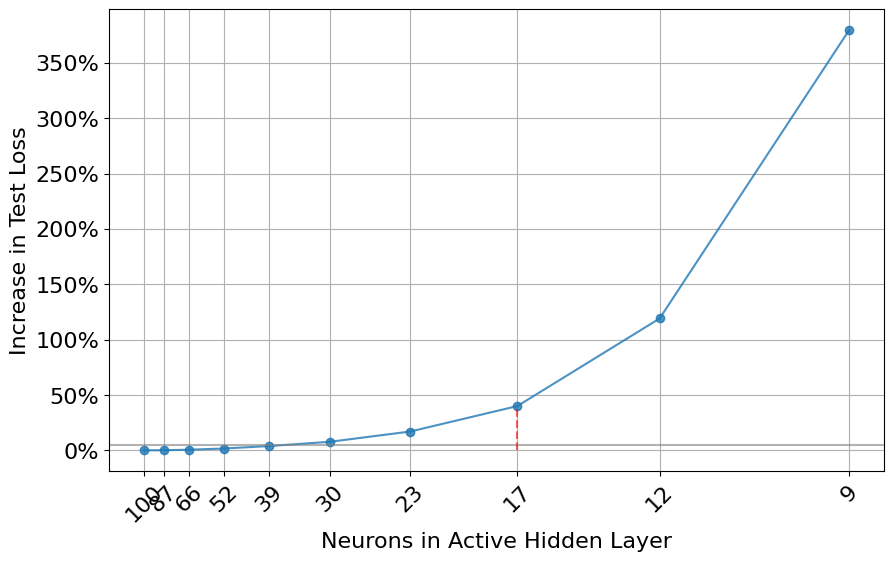

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import FuncFormatter

# Assuming these variables are defined elsewhere in your code
# TEACHER_LAYER_DIM, MAX_STUDENT_HIDDEN_DIMS, TRAIN_SIZE, student_network, test_dataloader, criterion, mean_test_loss_before_trimming

# Define the range of PRUNING_THRESHOLD values
# Define the start and end points on a logarithmic scale
start = 0.001
end = 0.013

# Generate 6 points uniformly spaced on a logarithmic scale
pruning_thresholds = np.logspace(np.log10(start), np.log10(end), 10)

# Lists to store results
percent_increases = []
non_zero_elements_counts = []

# Iterate over the PRUNING_THRESHOLD values
for PRUNING_THRESHOLD in pruning_thresholds:
    trimmed_net = deepcopy(student_network)
    number_of_trimmed_nodes = trimmed_net.trim_inactive_nodes(PRUNING_THRESHOLD)

    with torch.no_grad():
        test_loss = 0
        for x_batch, y_batch in test_dataloader:
            y_pred = trimmed_net(x_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
        mean_test_loss_after_trimming = test_loss / TRAIN_SIZE

        percent_increase = ((mean_test_loss_after_trimming - mean_test_loss_before_trimming) / mean_test_loss_before_trimming) * 100
        percent_increases.append(percent_increase)

        # Count non-zero elements in l2_diag
        non_zero_count = 0
        for name, param in trimmed_net.named_parameters():
            if 'l3_diag' in name:
                non_zero_count += torch.sum(torch.abs(param) <= PRUNING_THRESHOLD).item()
        non_zero_elements_counts.append(200 - non_zero_count)
        
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pruning_thresholds, percent_increases, marker='o', alpha=0.8)
plt.xlabel('Neurons in Active Hidden Layer')
plt.ylabel('Increase in Test Loss')
#plt.title('Percent Increase in Test Loss vs ')
plt.xticks(pruning_thresholds, labels=non_zero_elements_counts, rotation=45)
plt.axhline(y=5, color='gray', alpha=0.6)
plt.plot([pruning_thresholds[7], pruning_thresholds[7]], [0, percent_increases[7]], color='red', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.grid(True)

